# Logistic Regression

This notebook is an implemention of Logistic Regression to predict whether a student gets admitted into a university.
Suppose an administrator of a university department wants to determine each applicant's chance of admission based on their
results on two exams. We have historical data from previous applicants
that we can use as a training set for logistic regression. For each training
example, we have the applicant's scores on two exams and the admissions
decision.

Our task is to build a classification model that estimates an applicant's
probability of admission based on the scores from those two exams.

In [53]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

from mpl_toolkits import mplot3d
from IPython.core.debugger import set_trace

%matplotlib inline

In [54]:
# Load the dataset as a dataframe 'df'
df = pd.read_table('data1.txt', delimiter=',', names=('Exam_1', 'Exam_2', 'Admitted?'))

In [55]:
df.head()

,Exam_1,Exam_2,Admitted?
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
Exam_1       100 non-null float64
Exam_2       100 non-null float64
Admitted?    100 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


In [57]:
df.describe()

,Exam_1,Exam_2,Admitted?
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


## Visualizing the data

We can use scatterplot to visualize the data. In the plot, we can see that there is a nearly linear decision boundary. It curves a bit so we can’t classify all of the examples correctly using a straight line, but we should be able to get pretty close. 

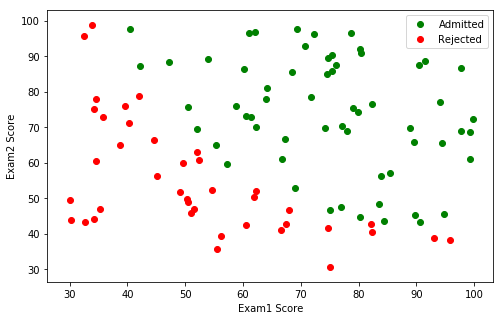

In [58]:
rejected = df[df['Admitted?']==0]
admitted = df[df['Admitted?']==1]

fig, ax = plt.subplots(figsize=(8,5))  
ax.scatter(admitted['Exam_1'], admitted['Exam_2'], c='g', marker='o', label='Admitted')  
ax.scatter(rejected['Exam_1'], rejected['Exam_2'], c='r', marker='o', label='Rejected')  

ax.legend(loc='upper right')

ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
plt.show()

## Implementation
The logistic regression hypothesis function is defined as:

$$ h_\theta(x) = g(\theta^Tx) $$

where function g is the sigmoid function. The sigmoid function is defined as:

$$ g(z) = \frac{1}{1+e^{-z}} $$

Now we need to implement logistic regression so we can train a model to find the optimal decision boundary and make class predictions. The first step is to implement the sigmoid function.

In [59]:
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

This function is the “activation” function for the output of logistic regression. It converts a continuous input into a value between zero and one. This value can be interpreted as the class probability, or the likelihood that the input example should be classified positively. Using this probability along with a threshold value, we can obtain a discrete label prediction. It helps to visualize the function’s output to see what it’s really doing:

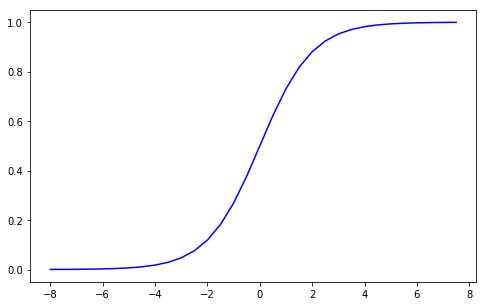

In [60]:
values = np.arange(-8, 8, step=0.5)

fig, ax = plt.subplots(figsize=(8,5))  
ax.plot(values, sigmoid(values), 'b')
plt.show()

## Compute Cost and Gradient

Our next step is to implement the cost function and gradient for logistic regression.
Recall that the cost function in logistic regression is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1 - h_\theta(x^{(i)}))] $$

and the gradient of the cost is a vector of the same length as $\theta$ where the jth
element (for j = 0,1,2,...,n) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression
have different definitions of $h_\theta(x)$

In [61]:
# Adding a column of 1's to the dataframe
df.insert(0, 'X0', 1)

n_columns = df.shape[1]  
X = df.iloc[:, 0:n_columns-1]  
y = df.iloc[:, n_columns-1:n_columns]

X = np.array(X.values)  
y = np.array(y.values)  
theta = np.zeros(3)
df.head()

,X0,Exam_1,Exam_2,Admitted?
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1


In [62]:
# Print first 5 rows of X to check the data
X[:5, :]

array([[  1.        ,  34.62365962,  78.02469282],
       [  1.        ,  30.28671077,  43.89499752],
       [  1.        ,  35.84740877,  72.90219803],
       [  1.        ,  60.18259939,  86.3085521 ],
       [  1.        ,  79.03273605,  75.34437644]])

In [63]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (3,))

In [64]:
def costFunction(theta, X, y):
    '''Define Cost function for Logistic Regression'''
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    J = np.sum(first - second) / (len(X))
    return J

In [65]:
def gradient(theta, X, y):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)

    return grad

In [66]:
cost_0 = costFunction(theta, X, y)
gradient_0 = gradient(theta, X, y)
print('Cost when theta is [0,0,0] = {0}'.format(cost_0))
print('Gradient when theta is [0,0,0] = {0}'.format(gradient_0))

Cost when theta is [0,0,0] = 0.6931471805599453
Gradient when theta is [0,0,0] = [ -0.1        -12.00921659 -11.26284221]


In [67]:
test_theta = np.array([-24, 0.2, 0.2])
test_cost = costFunction(test_theta, X, y)
print('Cost when theta is [-24, 0.2, 0.2] = {0}'.format(test_cost))

Cost when theta is [-24, 0.2, 0.2] = 0.21833019382659785


## Learning parameters using fmin_tnc() from scikit_learn module

By using the function 'gradient', we don't actually perform gradient descent. We just compute a single gradient step. In the following steps, we use SciPy's optimization API to optimize the parameters, given functions to compute the cost and the gradients.

In [68]:
result = opt.fmin_tnc(func=costFunction, x0=theta, fprime=gradient, args=(X, y))
theta_final = np.matrix(result[0])
J_min = costFunction(result[0], X, y)
print('Error calculated using optimal theta is = {0}'.format(J_min))

Error calculated using optimal theta is = 0.20349770158947425


### Plotting Decision Boundary

The decision boundary can be formed by joining the 2 blue 'x' in the graph shown below. This lines divides the data into 2 segments so this line will help us to predict the result based on exam scores.

In [69]:
print('Final theta learned using fmin_tnc is = {0}'.format(theta_final))

Final theta learned using fmin_tnc is = [[-25.16131872   0.20623159   0.20147149]]


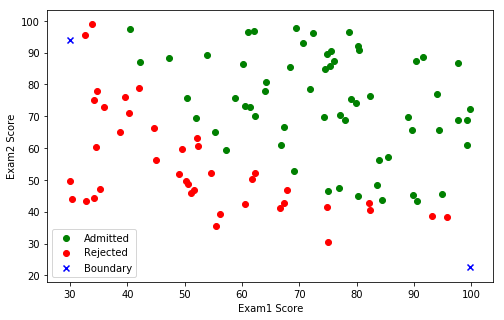

In [70]:
rejected = df[df['Admitted?']==0]
admitted = df[df['Admitted?']==1]

plot_X = np.asarray([[df['Exam_1'].min(), df['Exam_1'].max()]])
plot_y = np.asarray((-1/theta_final[0,2])*(theta_final[0,1]*plot_X + theta_final[0,0]))

fig, ax = plt.subplots(figsize=(8,5))  
ax.scatter(admitted['Exam_1'], admitted['Exam_2'], c='g', marker='o', label='Admitted')  
ax.scatter(rejected['Exam_1'], rejected['Exam_2'], c='r', marker='o', label='Rejected')  
ax.scatter(plot_X, plot_y, c='b', marker='x', label='Boundary')

ax.legend(loc='lower left')

ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
plt.show()

## Evaluating the Logistic Regression model

After learning the parameters, we can use the model to predict whether a
particular student will be admitted. For a student with an Exam 1 score
of 45 and an Exam 2 score of 85, the admission
probability is calculated below:

In [71]:
score_45_85 = sigmoid([1,45,85] * theta_final.T)
print('Admission probability for scores of 45 and 85 is = {0}'.format(score_45_85))

Admission probability for scores of 45 and 85 is = [[ 0.77629063]]


Another way to evaluate the quality of the parameters we have found
is to see how well the learned model predicts on our training set.

The predict function shown below, will produce '1' or '0' predictions given a dataset and a learned parameter
vector $\theta$. We can use this to report the training accuracy of our classifier by computing the
percentage of examples it got correct.

In [72]:
def predict(theta, X):
    h = sigmoid(X * theta.T)
    predictions = (h>=0.5)
    return predictions

In [73]:
predictions = predict(theta_final, X)
correct_predictions = [1 if ((pred == 1 and target == 1) or (pred == 0 and target == 0)) else 0 for (pred, target) in zip(predictions, y)]  
accuracy = (sum(map(int, correct_predictions)) % len(correct_predictions))  
print('Accuracy = {0}%'.format(accuracy))

accuracy = 89%


Our logistic regression classifer correctly predicted if a student was admitted or not 89% of the time. One point to note is that this is just training set accuracy. We did not keep a hold-out set or use cross-validation to get a true approximation of the accuracy so this number is likely higher than its true performance.